# 1. BTC/USD Dataset (Data split 7:3)

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [30]:
#import data
path = "../Dataset/BTC_USD-Binance-Historical-Data_New.csv"
data = pd.read_csv(path, index_col='Date', parse_dates=True)
data

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2024-06-01,"67,768.50","67,564.80","67,868.20","67,470.70",8.84K,0.33%
2024-05-31,"67,548.00","68,366.40","69,010.00","66,692.00",26.69K,-1.18%
2024-05-30,"68,352.20","67,652.70","69,500.00","67,141.80",28.48K,1.03%
2024-05-29,"67,652.40","68,425.10","68,914.00","67,150.00",23.16K,-1.06%
2024-05-28,"68,374.00","69,420.00","69,570.00","67,294.30",32.62K,-1.54%
...,...,...,...,...,...,...
2019-03-05,"3,857.50","3,716.10","3,876.00","3,705.40",30.82K,3.83%
2019-03-04,"3,715.00","3,807.80","3,828.00","3,674.90",32.61K,-2.40%
2019-03-03,"3,806.40","3,820.30","3,834.70","3,784.80",15.99K,-0.36%


In [31]:
data = data.sort_index(ascending=True)
data['Price'] = data['Price'].replace(',', '', regex=True).astype(float)
data.dropna(inplace=True)
data = data[['Price']]
data

,Price
Date,
2019-03-01,3823.2
2019-03-02,3820.0
2019-03-03,3806.4
2019-03-04,3715.0
2019-03-05,3857.5
...,...
2024-05-28,68374.0
2024-05-29,67652.4
2024-05-30,68352.2


In [32]:
scaler = MinMaxScaler()
price = scaler.fit_transform(data['Price'].values.reshape(-1, 1))

train_size = int(len(price) * 0.7)
test_size = len(price) - train_size

train_data = price[:train_size]
test_data = price[train_size:]

In [33]:
def create_dataset(data, window_size, slide_step):
    X, y = [], []
    for i in range(window_size, len(data) - slide_step + 1):
        X.append(data[i - window_size:i])
        y.append(data[i + slide_step - 1])
    return np.array(X), np.array(y)

In [34]:
window_sizes = [7, 14, 21, 30]
slide_steps = [1, 2, 3, 7]
best_params = {'window_size': None, 'slide_step': None, 'score': float('inf')}
for window_size in window_sizes:
    for slide_step in slide_steps:
        X_train, y_train = create_dataset(train_data, window_size, slide_step)
        X_test, y_test = create_dataset(test_data, window_size, slide_step)

        X_train = X_train.reshape(X_train.shape[0], -1)
        X_test = X_test.reshape(X_test.shape[0], -1)

        model = RandomForestRegressor(n_estimators=100, max_depth=10)
        model.fit(X_train, y_train)
        y_pred1 = model.predict(X_test)
        mean_score = mean_squared_error(y_test, y_pred1)

        if mean_score < best_params['score']:
            best_params['window_size'] = window_size
            best_params['slide_step'] = slide_step
            best_params['score'] = mean_score

window_size = best_params['window_size']
slide_step = best_params['slide_step']

print(f"Best Parameters: Window Size = {window_size}, Slide Step = {slide_step}")


c:\Users\ADMINS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\ADMINS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\ADMINS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\ADMINS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1474: DataCon

Best Parameters: Window Size = 7, Slide Step = 1


In [35]:
X_train, y_train = create_dataset(train_data, window_size, slide_step)
X_test, y_test = create_dataset(test_data, window_size, slide_step)

X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

In [36]:
model = RandomForestRegressor(n_estimators=100, max_depth=10)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_test = scaler.inverse_transform(y_test)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))

c:\Users\ADMINS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [37]:
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"MAE: {mae:.2f}")

RMSE: 1890.12
MAPE: 3.18%
MAE: 1211.36


In [38]:
def forecast_future_prices(model, last_window, window_size, scaler, days):
    future_prices = []
    current_window = last_window

    for _ in range(days):
        next_price = model.predict(current_window.reshape(1, -1))
        future_prices.append(next_price[0])
        current_window = np.append(current_window[1:], np.array([next_price]).
reshape(-1, current_window.shape[1]), axis=0)

    future_prices = np.array(future_prices).reshape(-1, 1)
    return scaler.inverse_transform(future_prices)

last_window = price[-window_size:]

future_prices_90 = forecast_future_prices(model, last_window, window_size,scaler, days=90)

In [39]:
train_data = scaler.inverse_transform(train_data)
test_data = scaler.inverse_transform(test_data)
y_train = scaler.inverse_transform(y_train)

In [40]:
last_timestep = data.index[-1]
future_index = pd.date_range(start=last_timestep + pd.DateOffset(days=1), periods=90)
future_index

DatetimeIndex(['2024-06-02', '2024-06-03', '2024-06-04', '2024-06-05',
               '2024-06-06', '2024-06-07', '2024-06-08', '2024-06-09',
               '2024-06-10', '2024-06-11', '2024-06-12', '2024-06-13',
               '2024-06-14', '2024-06-15', '2024-06-16', '2024-06-17',
               '2024-06-18', '2024-06-19', '2024-06-20', '2024-06-21',
               '2024-06-22', '2024-06-23', '2024-06-24', '2024-06-25',
               '2024-06-26', '2024-06-27', '2024-06-28', '2024-06-29',
               '2024-06-30', '2024-07-01', '2024-07-02', '2024-07-03',
               '2024-07-04', '2024-07-05', '2024-07-06', '2024-07-07',
               '2024-07-08', '2024-07-09', '2024-07-10', '2024-07-11',
               '2024-07-12', '2024-07-13', '2024-07-14', '2024-07-15',
               '2024-07-16', '2024-07-17', '2024-07-18', '2024-07-19',
               '2024-07-20', '2024-07-21', '2024-07-22', '2024-07-23',
               '2024-07-24', '2024-07-25', '2024-07-26', '2024-07-27',
      

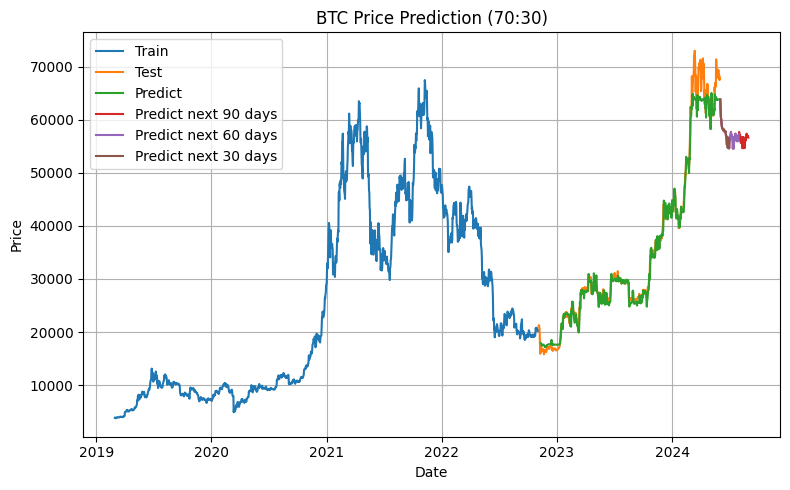

In [41]:
plt.figure(figsize=(8, 5))

train_data_index = data.index[:len(train_data)]
plt.plot(data.index[:len(train_data)], train_data, label="Train")
test_data_index = data.index[len(train_data):len(train_data) + len(test_data)]
plt.plot(test_data_index, test_data, label="Test")

predict_data_index = data.index[len(train_data) + window_size:len(train_data) + window_size + len(y_pred)]
plt.plot(predict_data_index, y_pred.flatten(), label="Predict", linestyle="-")

plt.plot(future_index[-90:], future_prices_90[-90:].flatten(), label="Predict next 90 days")
plt.plot(future_index[:60], future_prices_90[:60].flatten(), label="Predict next 60 days")
plt.plot(future_index[:30], future_prices_90[:30].flatten(), label="Predict next 30 days")
plt.title('BTC Price Prediction (70:30)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. ETH/USD Dataset (Data split 7:3)

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [43]:
#import data
path = "../Dataset/ETH_USD-Binance-Historical-Data-1_New.csv"
data = pd.read_csv(path, index_col='Date', parse_dates=True)
data

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2024-06-01,"3,815.93","3,765.83","3,832.37","3,753.29",132.67K,1.42%
2024-05-31,"3,762.59","3,748.31","3,845.00","3,724.51",273.40K,0.39%
2024-05-30,"3,747.91","3,767.15","3,824.91","3,703.70",277.03K,-0.58%
2024-05-29,"3,769.65","3,847.76","3,886.39","3,745.70",334.76K,-1.97%
2024-05-28,"3,845.56","3,894.21","3,929.20","3,775.00",416.24K,-1.25%
...,...,...,...,...,...,...
2019-03-05,136.59,125.75,137.86,125.14,1.04M,8.61%
2019-03-04,125.76,130.44,130.95,122.85,943.18K,-3.59%
2019-03-03,130.45,132.54,134.58,128.65,786.86K,-1.58%


In [44]:
data = data.sort_index(ascending=True)
data['Price'] = data['Price'].replace(',', '', regex=True).astype(float)
data.dropna(inplace=True)
data = data[['Price']]
data

,Price
Date,
2019-03-01,135.31
2019-03-02,132.54
2019-03-03,130.45
2019-03-04,125.76
2019-03-05,136.59
...,...
2024-05-28,3845.56
2024-05-29,3769.65
2024-05-30,3747.91


In [45]:
scaler = MinMaxScaler()
price = scaler.fit_transform(data['Price'].values.reshape(-1, 1))

train_size = int(len(price) * 0.7)
test_size = len(price) - train_size

train_data = price[:train_size]
test_data = price[train_size:]


In [46]:
def create_dataset(data, window_size, slide_step):
    X, y = [], []
    for i in range(window_size, len(data) - slide_step + 1):
        X.append(data[i - window_size:i])
        y.append(data[i + slide_step - 1])
    return np.array(X), np.array(y)

In [47]:
window_sizes = [7, 14, 21, 30]
slide_steps = [1, 2, 3, 7]
best_params = {'window_size': None, 'slide_step': None, 'score': float('inf')}
for window_size in window_sizes:
    for slide_step in slide_steps:
        X_train, y_train = create_dataset(train_data, window_size, slide_step)
        X_test, y_test = create_dataset(test_data, window_size, slide_step)

        X_train = X_train.reshape(X_train.shape[0], -1)
        X_test = X_test.reshape(X_test.shape[0], -1)

        model = RandomForestRegressor(n_estimators=100, max_depth=10)
        model.fit(X_train, y_train)
        y_pred1 = model.predict(X_test)
        mean_score = mean_squared_error(y_test, y_pred1)

        if mean_score < best_params['score']:
            best_params['window_size'] = window_size
            best_params['slide_step'] = slide_step
            best_params['score'] = mean_score

window_size = best_params['window_size']
slide_step = best_params['slide_step']

print(f"Best Parameters: Window Size = {window_size}, Slide Step = {slide_step}")


c:\Users\ADMINS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\ADMINS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\ADMINS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\ADMINS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1474: DataCon

Best Parameters: Window Size = 7, Slide Step = 1


In [48]:
X_train, y_train = create_dataset(train_data, window_size, slide_step)
X_test, y_test = create_dataset(test_data, window_size, slide_step)

X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

In [49]:
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_test = scaler.inverse_transform(y_test)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))

c:\Users\ADMINS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [50]:
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"MAE: {mae:.2f}")

RMSE: 77.44
MAPE: 2.43%
MAE: 53.09


In [51]:
def forecast_future_prices(model, last_window, window_size, scaler, days):
    future_prices = []
    current_window = last_window

    for _ in range(days):
        next_price = model.predict(current_window.reshape(1, -1))
        future_prices.append(next_price[0])
        current_window = np.append(current_window[1:], np.array([next_price]).
reshape(-1, current_window.shape[1]), axis=0)

    future_prices = np.array(future_prices).reshape(-1, 1)
    return scaler.inverse_transform(future_prices)

last_window = price[-window_size:]

future_prices_90 = forecast_future_prices(model, last_window, window_size,scaler, days=90)

In [52]:
train_data = scaler.inverse_transform(train_data)
test_data = scaler.inverse_transform(test_data)
y_train = scaler.inverse_transform(y_train)

In [53]:
last_timestep = data.index[-1]
future_index = pd.date_range(start=last_timestep + pd.DateOffset(days=1), 
periods=90)
future_index

DatetimeIndex(['2024-06-02', '2024-06-03', '2024-06-04', '2024-06-05',
               '2024-06-06', '2024-06-07', '2024-06-08', '2024-06-09',
               '2024-06-10', '2024-06-11', '2024-06-12', '2024-06-13',
               '2024-06-14', '2024-06-15', '2024-06-16', '2024-06-17',
               '2024-06-18', '2024-06-19', '2024-06-20', '2024-06-21',
               '2024-06-22', '2024-06-23', '2024-06-24', '2024-06-25',
               '2024-06-26', '2024-06-27', '2024-06-28', '2024-06-29',
               '2024-06-30', '2024-07-01', '2024-07-02', '2024-07-03',
               '2024-07-04', '2024-07-05', '2024-07-06', '2024-07-07',
               '2024-07-08', '2024-07-09', '2024-07-10', '2024-07-11',
               '2024-07-12', '2024-07-13', '2024-07-14', '2024-07-15',
               '2024-07-16', '2024-07-17', '2024-07-18', '2024-07-19',
               '2024-07-20', '2024-07-21', '2024-07-22', '2024-07-23',
               '2024-07-24', '2024-07-25', '2024-07-26', '2024-07-27',
      

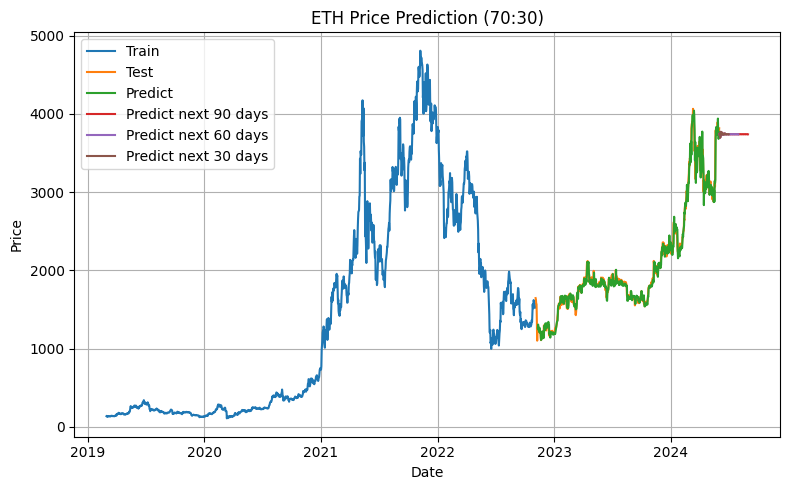

In [54]:
plt.figure(figsize=(8, 5))
train_data_index = data.index[:len(train_data)]
plt.plot(train_data_index, train_data, label="Train")

test_data_index = data.index[len(train_data):len(train_data) + len(test_data)]
plt.plot(test_data_index, test_data, label="Test")

predict_data_index = data.index[len(train_data) + window_size:len(train_data) + window_size + len(y_pred)]
plt.plot(predict_data_index, y_pred.flatten(), label="Predict", linestyle="-")

plt.plot(future_index[-90:], future_prices_90[-90:].flatten(), label="Predict next 90 days")
plt.plot(future_index[:60], future_prices_90[:60].flatten(), label="Predict next 60 days")
plt.plot(future_index[:30], future_prices_90[:30].flatten(), label="Predict next 30 days")
plt.title('ETH Price Prediction (70:30)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. BNB/USD Dataset (Data split 7:3)

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [56]:
path = "../Dataset/BNB_USD-Binance-Historical-Data_New.csv"
data = pd.read_csv(path, index_col='Date', parse_dates=True)
data

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2024-06-01,601.80,594.00,608.20,593.20,156.40K,1.35%
2024-05-31,593.80,595.00,598.90,590.10,168.61K,-0.20%
2024-05-30,595.00,595.70,601.80,586.60,225.46K,-0.10%
2024-05-29,595.60,601.90,603.60,593.30,212.71K,-1.01%
2024-05-28,601.70,603.80,605.50,594.30,284.87K,-0.35%
...,...,...,...,...,...,...
2019-03-05,13.65,11.40,13.74,11.40,8.34M,19.61%
2019-03-04,11.41,11.45,11.51,10.88,2.74M,-0.29%
2019-03-03,11.45,11.74,11.86,11.20,2.86M,-2.58%


In [57]:
data = data.sort_index(ascending=True)
data['Price'] = data['Price'].replace(',', '', regex=True).astype(float)
data.dropna(inplace=True)
data = data[['Price']]
data

,Price
Date,
2019-03-01,11.35
2019-03-02,11.75
2019-03-03,11.45
2019-03-04,11.41
2019-03-05,13.65
...,...
2024-05-28,601.70
2024-05-29,595.60
2024-05-30,595.00


In [58]:
scaler = MinMaxScaler()
price = scaler.fit_transform(data['Price'].values.reshape(-1, 1))

train_size = int(len(price) * 0.7)
test_size = len(price) - train_size

train_data = price[:train_size]
test_data = price[train_size:]

In [59]:
def create_dataset(data, window_size, slide_step):
    X, y = [], []
    for i in range(window_size, len(data) - slide_step + 1):
        X.append(data[i - window_size:i])
        y.append(data[i + slide_step - 1])
    return np.array(X), np.array(y)

In [60]:
window_sizes = [7, 14, 21, 30]
slide_steps = [1, 2, 3, 7]
best_params = {'window_size': None, 'slide_step': None, 'score': float('inf')}
for window_size in window_sizes:
    for slide_step in slide_steps:
        X_train, y_train = create_dataset(train_data, window_size, slide_step)
        X_test, y_test = create_dataset(test_data, window_size, slide_step)

        X_train = X_train.reshape(X_train.shape[0], -1)
        X_test = X_test.reshape(X_test.shape[0], -1)

        model = RandomForestRegressor(n_estimators=100, max_depth=10)
        model.fit(X_train, y_train)
        y_pred1 = model.predict(X_test)
        mean_score = mean_squared_error(y_test, y_pred1)

        if mean_score < best_params['score']:
            best_params['window_size'] = window_size
            best_params['slide_step'] = slide_step
            best_params['score'] = mean_score

window_size = best_params['window_size']
slide_step = best_params['slide_step']

print(f"Best Parameters: Window Size = {window_size}, Slide Step = {slide_step}")


c:\Users\ADMINS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\ADMINS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\ADMINS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\ADMINS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1474: DataCon

Best Parameters: Window Size = 14, Slide Step = 1


In [61]:
X_train, y_train = create_dataset(train_data, window_size, slide_step)
X_test, y_test = create_dataset(test_data, window_size, slide_step)

X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

In [62]:
model = RandomForestRegressor(n_estimators=100, max_depth=10)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_test = scaler.inverse_transform(y_test)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))

c:\Users\ADMINS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [63]:
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"MAE: {mae:.2f}")

RMSE: 12.96
MAPE: 2.87%
MAE: 9.05


In [64]:
def forecast_future_prices(model, last_window, window_size, scaler, days):
    future_prices = []
    current_window = last_window

    for _ in range(days):
        next_price = model.predict(current_window.reshape(1, -1))
        future_prices.append(next_price[0])
        current_window = np.append(current_window[1:], np.array([next_price]).
reshape(-1, current_window.shape[1]), axis=0)

    future_prices = np.array(future_prices).reshape(-1, 1)
    return scaler.inverse_transform(future_prices)

last_window = price[-window_size:]

future_prices_90 = forecast_future_prices(model, last_window, window_size,scaler, days=90)

In [65]:
train_data = scaler.inverse_transform(train_data)
test_data = scaler.inverse_transform(test_data)
y_train = scaler.inverse_transform(y_train)

In [66]:
last_timestep = data.index[-1]
future_index = pd.date_range(start=last_timestep + pd.DateOffset(days=1), 
periods=90)
future_index

DatetimeIndex(['2024-06-02', '2024-06-03', '2024-06-04', '2024-06-05',
               '2024-06-06', '2024-06-07', '2024-06-08', '2024-06-09',
               '2024-06-10', '2024-06-11', '2024-06-12', '2024-06-13',
               '2024-06-14', '2024-06-15', '2024-06-16', '2024-06-17',
               '2024-06-18', '2024-06-19', '2024-06-20', '2024-06-21',
               '2024-06-22', '2024-06-23', '2024-06-24', '2024-06-25',
               '2024-06-26', '2024-06-27', '2024-06-28', '2024-06-29',
               '2024-06-30', '2024-07-01', '2024-07-02', '2024-07-03',
               '2024-07-04', '2024-07-05', '2024-07-06', '2024-07-07',
               '2024-07-08', '2024-07-09', '2024-07-10', '2024-07-11',
               '2024-07-12', '2024-07-13', '2024-07-14', '2024-07-15',
               '2024-07-16', '2024-07-17', '2024-07-18', '2024-07-19',
               '2024-07-20', '2024-07-21', '2024-07-22', '2024-07-23',
               '2024-07-24', '2024-07-25', '2024-07-26', '2024-07-27',
      

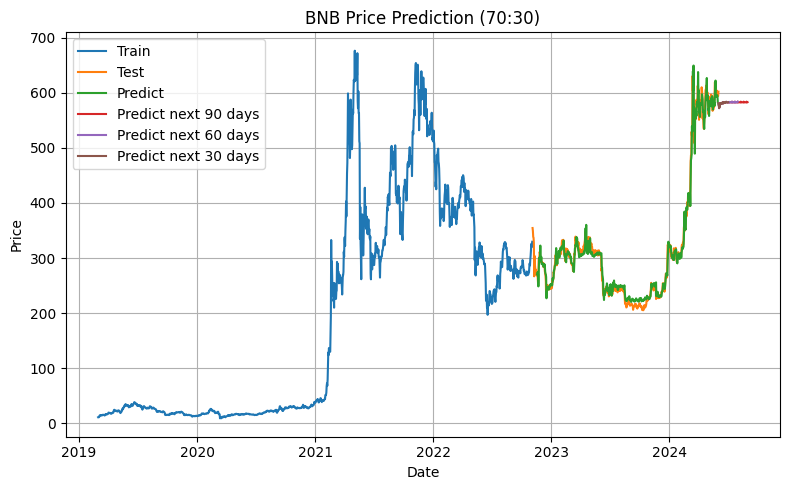

In [67]:
plt.figure(figsize=(8, 5))
train_data_index = data.index[:len(train_data)]
plt.plot(train_data_index, train_data, label="Train")

test_data_index = data.index[len(train_data):len(train_data) + len(test_data)]
plt.plot(test_data_index, test_data, label="Test")

predict_data_index = data.index[len(train_data) + window_size:len(train_data) + window_size + len(y_pred)]
plt.plot(predict_data_index, y_pred.flatten(), label="Predict", linestyle="-")

plt.plot(future_index[-90:], future_prices_90[-90:].flatten(), label="Predict next 90 days")
plt.plot(future_index[:60], future_prices_90[:60].flatten(), label="Predict next 60 days")
plt.plot(future_index[:30], future_prices_90[:30].flatten(), label="Predict next 30 days")
plt.title('BNB Price Prediction (70:30)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. BTC/USD Dataset (Data split 8:2)

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [69]:
path = "../Dataset/BTC_USD-Binance-Historical-Data_New.csv"
data = pd.read_csv(path, index_col='Date', parse_dates=True)
data

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2024-06-01,"67,768.50","67,564.80","67,868.20","67,470.70",8.84K,0.33%
2024-05-31,"67,548.00","68,366.40","69,010.00","66,692.00",26.69K,-1.18%
2024-05-30,"68,352.20","67,652.70","69,500.00","67,141.80",28.48K,1.03%
2024-05-29,"67,652.40","68,425.10","68,914.00","67,150.00",23.16K,-1.06%
2024-05-28,"68,374.00","69,420.00","69,570.00","67,294.30",32.62K,-1.54%
...,...,...,...,...,...,...
2019-03-05,"3,857.50","3,716.10","3,876.00","3,705.40",30.82K,3.83%
2019-03-04,"3,715.00","3,807.80","3,828.00","3,674.90",32.61K,-2.40%
2019-03-03,"3,806.40","3,820.30","3,834.70","3,784.80",15.99K,-0.36%


In [70]:
data = data.sort_index(ascending=True)
data['Price'] = data['Price'].replace(',', '', regex=True).astype(float)
data.dropna(inplace=True)
data = data[['Price']]
data

,Price
Date,
2019-03-01,3823.2
2019-03-02,3820.0
2019-03-03,3806.4
2019-03-04,3715.0
2019-03-05,3857.5
...,...
2024-05-28,68374.0
2024-05-29,67652.4
2024-05-30,68352.2


In [71]:
scaler = MinMaxScaler()
price = scaler.fit_transform(data['Price'].values.reshape(-1, 1))

train_size = int(len(price) * 0.8)
test_size = len(price) - train_size

train_data = price[:train_size]
test_data = price[train_size:]

In [72]:
def create_dataset(data, window_size, slide_step):
    X, y = [], []
    for i in range(window_size, len(data) - slide_step + 1):
        X.append(data[i - window_size:i])
        y.append(data[i + slide_step - 1])
    return np.array(X), np.array(y)

In [73]:
window_sizes = [7, 14, 21, 30]
slide_steps = [1, 2, 3, 7]
best_params = {'window_size': None, 'slide_step': None, 'score': float('inf')}
for window_size in window_sizes:
    for slide_step in slide_steps:
        X_train, y_train = create_dataset(train_data, window_size, slide_step)
        X_test, y_test = create_dataset(test_data, window_size, slide_step)

        X_train = X_train.reshape(X_train.shape[0], -1)
        X_test = X_test.reshape(X_test.shape[0], -1)

        model = RandomForestRegressor(n_estimators=100, max_depth=10)
        model.fit(X_train, y_train)
        y_pred1 = model.predict(X_test)
        mean_score = mean_squared_error(y_test, y_pred1)

        if mean_score < best_params['score']:
            best_params['window_size'] = window_size
            best_params['slide_step'] = slide_step
            best_params['score'] = mean_score

window_size = best_params['window_size']
slide_step = best_params['slide_step']

print(f"Best Parameters: Window Size = {window_size}, Slide Step = {slide_step}")


c:\Users\ADMINS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\ADMINS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\ADMINS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\ADMINS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1474: DataCon

Best Parameters: Window Size = 7, Slide Step = 1


In [74]:
X_train, y_train = create_dataset(train_data, window_size, slide_step)
X_test, y_test = create_dataset(test_data, window_size, slide_step)

X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

In [75]:
model = RandomForestRegressor(n_estimators=100, max_depth=10)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_test = scaler.inverse_transform(y_test)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))

c:\Users\ADMINS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [76]:
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"MAE: {mae:.2f}")

RMSE: 2271.28
MAPE: 2.77%
MAE: 1390.68


In [77]:
def forecast_future_prices(model, last_window, window_size, scaler, days):
    future_prices = []
    current_window = last_window

    for _ in range(days):
        next_price = model.predict(current_window.reshape(1, -1))
        future_prices.append(next_price[0])
        current_window = np.append(current_window[1:], np.array([next_price]).
reshape(-1, current_window.shape[1]), axis=0)

    future_prices = np.array(future_prices).reshape(-1, 1)
    return scaler.inverse_transform(future_prices)

last_window = price[-window_size:]

future_prices_90 = forecast_future_prices(model, last_window, window_size,scaler, days=90)

In [78]:
train_data = scaler.inverse_transform(train_data)
test_data = scaler.inverse_transform(test_data)
y_train = scaler.inverse_transform(y_train)

In [79]:
last_timestep = data.index[-1]
future_index = pd.date_range(start=last_timestep + pd.DateOffset(days=1), 
periods=90)
future_index

DatetimeIndex(['2024-06-02', '2024-06-03', '2024-06-04', '2024-06-05',
               '2024-06-06', '2024-06-07', '2024-06-08', '2024-06-09',
               '2024-06-10', '2024-06-11', '2024-06-12', '2024-06-13',
               '2024-06-14', '2024-06-15', '2024-06-16', '2024-06-17',
               '2024-06-18', '2024-06-19', '2024-06-20', '2024-06-21',
               '2024-06-22', '2024-06-23', '2024-06-24', '2024-06-25',
               '2024-06-26', '2024-06-27', '2024-06-28', '2024-06-29',
               '2024-06-30', '2024-07-01', '2024-07-02', '2024-07-03',
               '2024-07-04', '2024-07-05', '2024-07-06', '2024-07-07',
               '2024-07-08', '2024-07-09', '2024-07-10', '2024-07-11',
               '2024-07-12', '2024-07-13', '2024-07-14', '2024-07-15',
               '2024-07-16', '2024-07-17', '2024-07-18', '2024-07-19',
               '2024-07-20', '2024-07-21', '2024-07-22', '2024-07-23',
               '2024-07-24', '2024-07-25', '2024-07-26', '2024-07-27',
      

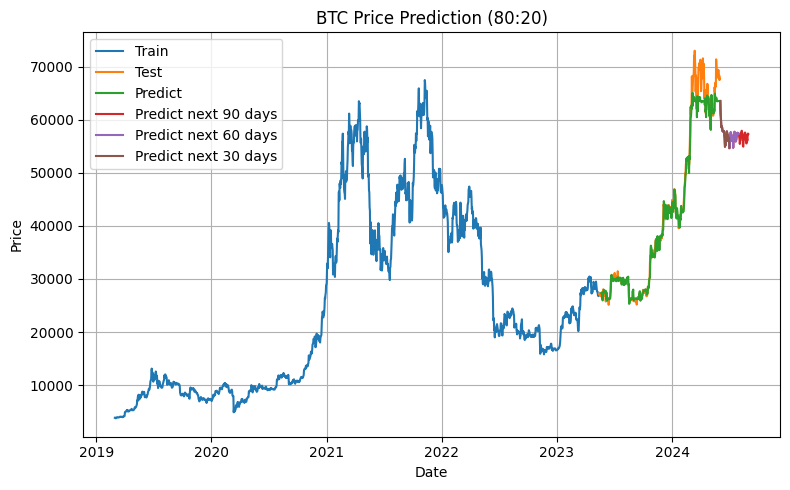

In [80]:
plt.figure(figsize=(8, 5))

train_data_index = data.index[:len(train_data)]
plt.plot(data.index[:len(train_data)], train_data, label="Train")
test_data_index = data.index[len(train_data):len(train_data) + len(test_data)]
plt.plot(test_data_index, test_data, label="Test")

predict_data_index = data.index[len(train_data) + window_size:len(train_data) + window_size + len(y_pred)]
plt.plot(predict_data_index, y_pred.flatten(), label="Predict", linestyle="-")

plt.plot(future_index[-90:], future_prices_90[-90:].flatten(), label="Predict next 90 days")
plt.plot(future_index[:60], future_prices_90[:60].flatten(), label="Predict next 60 days")
plt.plot(future_index[:30], future_prices_90[:30].flatten(), label="Predict next 30 days")
plt.title('BTC Price Prediction (80:20)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 5. ETH/USD Dataset (Data split 8:2)

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [82]:
#import data
path = "../Dataset/ETH_USD-Binance-Historical-Data-1_New.csv"
data = pd.read_csv(path, index_col='Date', parse_dates=True)
data

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2024-06-01,"3,815.93","3,765.83","3,832.37","3,753.29",132.67K,1.42%
2024-05-31,"3,762.59","3,748.31","3,845.00","3,724.51",273.40K,0.39%
2024-05-30,"3,747.91","3,767.15","3,824.91","3,703.70",277.03K,-0.58%
2024-05-29,"3,769.65","3,847.76","3,886.39","3,745.70",334.76K,-1.97%
2024-05-28,"3,845.56","3,894.21","3,929.20","3,775.00",416.24K,-1.25%
...,...,...,...,...,...,...
2019-03-05,136.59,125.75,137.86,125.14,1.04M,8.61%
2019-03-04,125.76,130.44,130.95,122.85,943.18K,-3.59%
2019-03-03,130.45,132.54,134.58,128.65,786.86K,-1.58%


In [83]:
data = data.sort_index(ascending=True)
data['Price'] = data['Price'].replace(',', '', regex=True).astype(float)
data.dropna(inplace=True)
data = data[['Price']]
data

,Price
Date,
2019-03-01,135.31
2019-03-02,132.54
2019-03-03,130.45
2019-03-04,125.76
2019-03-05,136.59
...,...
2024-05-28,3845.56
2024-05-29,3769.65
2024-05-30,3747.91


In [84]:
scaler = MinMaxScaler()
price = scaler.fit_transform(data['Price'].values.reshape(-1, 1))

train_size = int(len(price) * 0.8)
test_size = len(price) - train_size

train_data = price[:train_size]
test_data = price[train_size:]

In [85]:
def create_dataset(data, window_size, slide_step):
    X, y = [], []
    for i in range(window_size, len(data) - slide_step + 1):
        X.append(data[i - window_size:i])
        y.append(data[i + slide_step - 1])
    return np.array(X), np.array(y)

In [86]:
window_sizes = [7, 14, 21, 30]
slide_steps = [1, 2, 3, 7]
best_params = {'window_size': None, 'slide_step': None, 'score': float('inf')}
for window_size in window_sizes:
    for slide_step in slide_steps:
        X_train, y_train = create_dataset(train_data, window_size, slide_step)
        X_test, y_test = create_dataset(test_data, window_size, slide_step)

        X_train = X_train.reshape(X_train.shape[0], -1)
        X_test = X_test.reshape(X_test.shape[0], -1)

        model = RandomForestRegressor(n_estimators=100, max_depth=10)
        model.fit(X_train, y_train)
        y_pred1 = model.predict(X_test)
        mean_score = mean_squared_error(y_test, y_pred1)

        if mean_score < best_params['score']:
            best_params['window_size'] = window_size
            best_params['slide_step'] = slide_step
            best_params['score'] = mean_score

window_size = best_params['window_size']
slide_step = best_params['slide_step']

print(f"Best Parameters: Window Size = {window_size}, Slide Step = {slide_step}")

c:\Users\ADMINS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\ADMINS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\ADMINS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\ADMINS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1474: DataCon

Best Parameters: Window Size = 7, Slide Step = 1


In [87]:
X_train, y_train = create_dataset(train_data, window_size, slide_step)
X_test, y_test = create_dataset(test_data, window_size, slide_step)

X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

In [88]:
model = RandomForestRegressor(n_estimators=100, max_depth=10)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_test = scaler.inverse_transform(y_test)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))

c:\Users\ADMINS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [89]:
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"MAE: {mae:.2f}")

RMSE: 87.33
MAPE: 2.26%
MAE: 57.24


In [90]:
def forecast_future_prices(model, last_window, window_size, scaler, days):
    future_prices = []
    current_window = last_window

    for _ in range(days):
        next_price = model.predict(current_window.reshape(1, -1))
        future_prices.append(next_price[0])
        current_window = np.append(current_window[1:], np.array([next_price]).
reshape(-1, current_window.shape[1]), axis=0)

    future_prices = np.array(future_prices).reshape(-1, 1)
    return scaler.inverse_transform(future_prices)

last_window = price[-window_size:]

future_prices_90 = forecast_future_prices(model, last_window, window_size,scaler, days=90)

In [91]:
train_data = scaler.inverse_transform(train_data)
test_data = scaler.inverse_transform(test_data)
y_train = scaler.inverse_transform(y_train)

In [92]:
last_timestep = data.index[-1]
future_index = pd.date_range(start=last_timestep + pd.DateOffset(days=1), 
periods=90)
future_index

DatetimeIndex(['2024-06-02', '2024-06-03', '2024-06-04', '2024-06-05',
               '2024-06-06', '2024-06-07', '2024-06-08', '2024-06-09',
               '2024-06-10', '2024-06-11', '2024-06-12', '2024-06-13',
               '2024-06-14', '2024-06-15', '2024-06-16', '2024-06-17',
               '2024-06-18', '2024-06-19', '2024-06-20', '2024-06-21',
               '2024-06-22', '2024-06-23', '2024-06-24', '2024-06-25',
               '2024-06-26', '2024-06-27', '2024-06-28', '2024-06-29',
               '2024-06-30', '2024-07-01', '2024-07-02', '2024-07-03',
               '2024-07-04', '2024-07-05', '2024-07-06', '2024-07-07',
               '2024-07-08', '2024-07-09', '2024-07-10', '2024-07-11',
               '2024-07-12', '2024-07-13', '2024-07-14', '2024-07-15',
               '2024-07-16', '2024-07-17', '2024-07-18', '2024-07-19',
               '2024-07-20', '2024-07-21', '2024-07-22', '2024-07-23',
               '2024-07-24', '2024-07-25', '2024-07-26', '2024-07-27',
      

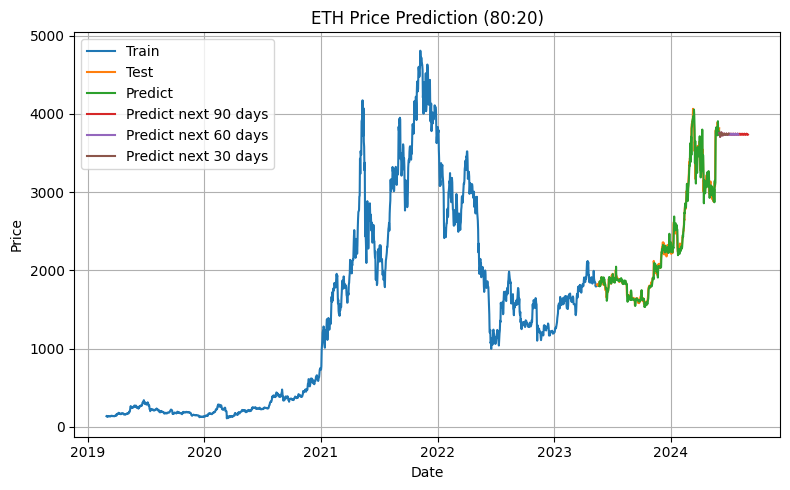

In [93]:
plt.figure(figsize=(8, 5))

train_data_index = data.index[:len(train_data)]
plt.plot(data.index[:len(train_data)], train_data, label="Train")
test_data_index = data.index[len(train_data):len(train_data) + len(test_data)]
plt.plot(test_data_index, test_data, label="Test")

predict_data_index = data.index[len(train_data) + window_size:len(train_data) + window_size + len(y_pred)]
plt.plot(predict_data_index, y_pred.flatten(), label="Predict", linestyle="-")

plt.plot(future_index[-90:], future_prices_90[-90:].flatten(), label="Predict next 90 days")
plt.plot(future_index[:60], future_prices_90[:60].flatten(), label="Predict next 60 days")
plt.plot(future_index[:30], future_prices_90[:30].flatten(), label="Predict next 30 days")
plt.title('ETH Price Prediction (80:20)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 6. BNB/USD Dataset (Data split 8:2)

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [95]:
#import data
path = "../Dataset/BNB_USD-Binance-Historical-Data_New.csv"
data = pd.read_csv(path, index_col='Date', parse_dates=True)
data

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2024-06-01,601.80,594.00,608.20,593.20,156.40K,1.35%
2024-05-31,593.80,595.00,598.90,590.10,168.61K,-0.20%
2024-05-30,595.00,595.70,601.80,586.60,225.46K,-0.10%
2024-05-29,595.60,601.90,603.60,593.30,212.71K,-1.01%
2024-05-28,601.70,603.80,605.50,594.30,284.87K,-0.35%
...,...,...,...,...,...,...
2019-03-05,13.65,11.40,13.74,11.40,8.34M,19.61%
2019-03-04,11.41,11.45,11.51,10.88,2.74M,-0.29%
2019-03-03,11.45,11.74,11.86,11.20,2.86M,-2.58%


In [96]:
data = data.sort_index(ascending=True)
data['Price'] = data['Price'].replace(',', '', regex=True).astype(float)
data.dropna(inplace=True)
data = data[['Price']]
data

,Price
Date,
2019-03-01,11.35
2019-03-02,11.75
2019-03-03,11.45
2019-03-04,11.41
2019-03-05,13.65
...,...
2024-05-28,601.70
2024-05-29,595.60
2024-05-30,595.00


In [97]:
scaler = MinMaxScaler()
price = scaler.fit_transform(data['Price'].values.reshape(-1, 1))

train_size = int(len(price) * 0.8)
test_size = len(price) - train_size

train_data = price[:train_size]
test_data = price[train_size:]

In [98]:
def create_dataset(data, window_size, slide_step):
    X, y = [], []
    for i in range(window_size, len(data) - slide_step + 1):
        X.append(data[i - window_size:i])
        y.append(data[i + slide_step - 1])
    return np.array(X), np.array(y)

In [99]:
window_sizes = [7, 14, 21, 30]
slide_steps = [1, 2, 3, 7]
best_params = {'window_size': None, 'slide_step': None, 'score': float('inf')}
for window_size in window_sizes:
    for slide_step in slide_steps:
        X_train, y_train = create_dataset(train_data, window_size, slide_step)
        X_test, y_test = create_dataset(test_data, window_size, slide_step)

        X_train = X_train.reshape(X_train.shape[0], -1)
        X_test = X_test.reshape(X_test.shape[0], -1)

        model = RandomForestRegressor(n_estimators=100, max_depth=10)
        model.fit(X_train, y_train)
        y_pred1 = model.predict(X_test)
        mean_score = mean_squared_error(y_test, y_pred1)

        if mean_score < best_params['score']:
            best_params['window_size'] = window_size
            best_params['slide_step'] = slide_step
            best_params['score'] = mean_score

window_size = best_params['window_size']
slide_step = best_params['slide_step']

print(f"Best Parameters: Window Size = {window_size}, Slide Step = {slide_step}")


c:\Users\ADMINS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\ADMINS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\ADMINS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\ADMINS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1474: DataCon

Best Parameters: Window Size = 14, Slide Step = 1


In [100]:
X_train, y_train = create_dataset(train_data, window_size, slide_step)
X_test, y_test = create_dataset(test_data, window_size, slide_step)

X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

In [101]:
model = RandomForestRegressor(n_estimators=100, max_depth=10)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_test = scaler.inverse_transform(y_test)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))

c:\Users\ADMINS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [102]:
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"MAE: {mae:.2f}")

RMSE: 13.45
MAPE: 2.47%
MAE: 8.32


In [103]:
def forecast_future_prices(model, last_window, window_size, scaler, days):
    future_prices = []
    current_window = last_window

    for _ in range(days):
        next_price = model.predict(current_window.reshape(1, -1))
        future_prices.append(next_price[0])
        current_window = np.append(current_window[1:], np.array([next_price]).
reshape(-1, current_window.shape[1]), axis=0)

    future_prices = np.array(future_prices).reshape(-1, 1)
    return scaler.inverse_transform(future_prices)

last_window = price[-window_size:]

future_prices_90 = forecast_future_prices(model, last_window, window_size,scaler, days=90)

In [104]:
train_data = scaler.inverse_transform(train_data)
test_data = scaler.inverse_transform(test_data)
y_train = scaler.inverse_transform(y_train)

In [105]:
last_timestep = data.index[-1]
future_index = pd.date_range(start=last_timestep + pd.DateOffset(days=1), 
periods=90)
future_index

DatetimeIndex(['2024-06-02', '2024-06-03', '2024-06-04', '2024-06-05',
               '2024-06-06', '2024-06-07', '2024-06-08', '2024-06-09',
               '2024-06-10', '2024-06-11', '2024-06-12', '2024-06-13',
               '2024-06-14', '2024-06-15', '2024-06-16', '2024-06-17',
               '2024-06-18', '2024-06-19', '2024-06-20', '2024-06-21',
               '2024-06-22', '2024-06-23', '2024-06-24', '2024-06-25',
               '2024-06-26', '2024-06-27', '2024-06-28', '2024-06-29',
               '2024-06-30', '2024-07-01', '2024-07-02', '2024-07-03',
               '2024-07-04', '2024-07-05', '2024-07-06', '2024-07-07',
               '2024-07-08', '2024-07-09', '2024-07-10', '2024-07-11',
               '2024-07-12', '2024-07-13', '2024-07-14', '2024-07-15',
               '2024-07-16', '2024-07-17', '2024-07-18', '2024-07-19',
               '2024-07-20', '2024-07-21', '2024-07-22', '2024-07-23',
               '2024-07-24', '2024-07-25', '2024-07-26', '2024-07-27',
      

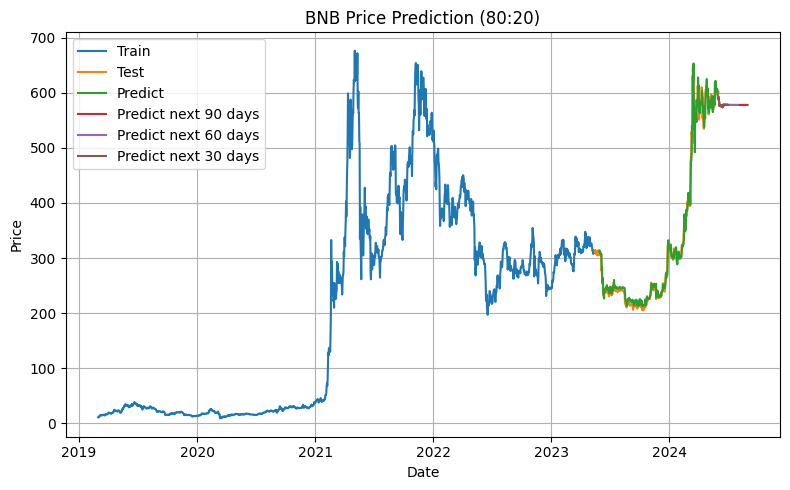

In [106]:
plt.figure(figsize=(8, 5))

train_data_index = data.index[:len(train_data)]
plt.plot(data.index[:len(train_data)], train_data, label="Train")
test_data_index = data.index[len(train_data):len(train_data) + len(test_data)]
plt.plot(test_data_index, test_data, label="Test")

predict_data_index = data.index[len(train_data) + window_size:len(train_data) + window_size + len(y_pred)]
plt.plot(predict_data_index, y_pred.flatten(), label="Predict", linestyle="-")

plt.plot(future_index[-90:], future_prices_90[-90:].flatten(), label="Predict next 90 days")
plt.plot(future_index[:60], future_prices_90[:60].flatten(), label="Predict next 60 days")
plt.plot(future_index[:30], future_prices_90[:30].flatten(), label="Predict next 30 days")
plt.title('BNB Price Prediction (80:20)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. BTC/USD Dataset (Data split 9:1)

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [108]:
path = "../Dataset/BTC_USD-Binance-Historical-Data_New.csv"
data = pd.read_csv(path, index_col='Date', parse_dates=True)
data

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2024-06-01,"67,768.50","67,564.80","67,868.20","67,470.70",8.84K,0.33%
2024-05-31,"67,548.00","68,366.40","69,010.00","66,692.00",26.69K,-1.18%
2024-05-30,"68,352.20","67,652.70","69,500.00","67,141.80",28.48K,1.03%
2024-05-29,"67,652.40","68,425.10","68,914.00","67,150.00",23.16K,-1.06%
2024-05-28,"68,374.00","69,420.00","69,570.00","67,294.30",32.62K,-1.54%
...,...,...,...,...,...,...
2019-03-05,"3,857.50","3,716.10","3,876.00","3,705.40",30.82K,3.83%
2019-03-04,"3,715.00","3,807.80","3,828.00","3,674.90",32.61K,-2.40%
2019-03-03,"3,806.40","3,820.30","3,834.70","3,784.80",15.99K,-0.36%


In [109]:
data = data.sort_index(ascending=True)
data['Price'] = data['Price'].replace(',', '', regex=True).astype(float)
data.dropna(inplace=True)
data = data[['Price']]
data

,Price
Date,
2019-03-01,3823.2
2019-03-02,3820.0
2019-03-03,3806.4
2019-03-04,3715.0
2019-03-05,3857.5
...,...
2024-05-28,68374.0
2024-05-29,67652.4
2024-05-30,68352.2


In [110]:
scaler = MinMaxScaler()
price = scaler.fit_transform(data['Price'].values.reshape(-1, 1))

train_size = int(len(price) * 0.9)
test_size = len(price) - train_size

train_data = price[:train_size]
test_data = price[train_size:]

In [111]:
def create_dataset(data, window_size, slide_step):
    X, y = [], []
    for i in range(window_size, len(data) - slide_step + 1):
        X.append(data[i - window_size:i])
        y.append(data[i + slide_step - 1])
    return np.array(X), np.array(y)

In [112]:
window_sizes = [7, 14, 21, 30]
slide_steps = [1, 2, 3, 7]
best_params = {'window_size': None, 'slide_step': None, 'score': float('inf')}
for window_size in window_sizes:
    for slide_step in slide_steps:
        X_train, y_train = create_dataset(train_data, window_size, slide_step)
        X_test, y_test = create_dataset(test_data, window_size, slide_step)

        X_train = X_train.reshape(X_train.shape[0], -1)
        X_test = X_test.reshape(X_test.shape[0], -1)

        model = RandomForestRegressor(n_estimators=100, max_depth=10)
        model.fit(X_train, y_train)
        y_pred1 = model.predict(X_test)
        mean_score = mean_squared_error(y_test, y_pred1)

        if mean_score < best_params['score']:
            best_params['window_size'] = window_size
            best_params['slide_step'] = slide_step
            best_params['score'] = mean_score

window_size = best_params['window_size']
slide_step = best_params['slide_step']

print(f"Best Parameters: Window Size = {window_size}, Slide Step = {slide_step}")


c:\Users\ADMINS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\ADMINS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\ADMINS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\ADMINS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1474: DataCon

Best Parameters: Window Size = 21, Slide Step = 1


In [113]:
X_train, y_train = create_dataset(train_data, window_size, slide_step)
X_test, y_test = create_dataset(test_data, window_size, slide_step)

X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

In [114]:
model = RandomForestRegressor(n_estimators=100, max_depth=10)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_test = scaler.inverse_transform(y_test)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))

c:\Users\ADMINS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [115]:
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"MAE: {mae:.2f}")

RMSE: 3063.31
MAPE: 3.51%
MAE: 2180.00


In [116]:
def forecast_future_prices(model, last_window, window_size, scaler, days):
    future_prices = []
    current_window = last_window

    for _ in range(days):
        next_price = model.predict(current_window.reshape(1, -1))
        future_prices.append(next_price[0])
        current_window = np.append(current_window[1:], np.array([next_price]).
reshape(-1, current_window.shape[1]), axis=0)

    future_prices = np.array(future_prices).reshape(-1, 1)
    return scaler.inverse_transform(future_prices)

last_window = price[-window_size:]

future_prices_90 = forecast_future_prices(model, last_window, window_size,scaler, days=90)

In [117]:
train_data = scaler.inverse_transform(train_data)
test_data = scaler.inverse_transform(test_data)
y_train = scaler.inverse_transform(y_train)

In [118]:
last_timestep = data.index[-1]
future_index = pd.date_range(start=last_timestep + pd.DateOffset(days=1), 
periods=90)
future_index

DatetimeIndex(['2024-06-02', '2024-06-03', '2024-06-04', '2024-06-05',
               '2024-06-06', '2024-06-07', '2024-06-08', '2024-06-09',
               '2024-06-10', '2024-06-11', '2024-06-12', '2024-06-13',
               '2024-06-14', '2024-06-15', '2024-06-16', '2024-06-17',
               '2024-06-18', '2024-06-19', '2024-06-20', '2024-06-21',
               '2024-06-22', '2024-06-23', '2024-06-24', '2024-06-25',
               '2024-06-26', '2024-06-27', '2024-06-28', '2024-06-29',
               '2024-06-30', '2024-07-01', '2024-07-02', '2024-07-03',
               '2024-07-04', '2024-07-05', '2024-07-06', '2024-07-07',
               '2024-07-08', '2024-07-09', '2024-07-10', '2024-07-11',
               '2024-07-12', '2024-07-13', '2024-07-14', '2024-07-15',
               '2024-07-16', '2024-07-17', '2024-07-18', '2024-07-19',
               '2024-07-20', '2024-07-21', '2024-07-22', '2024-07-23',
               '2024-07-24', '2024-07-25', '2024-07-26', '2024-07-27',
      

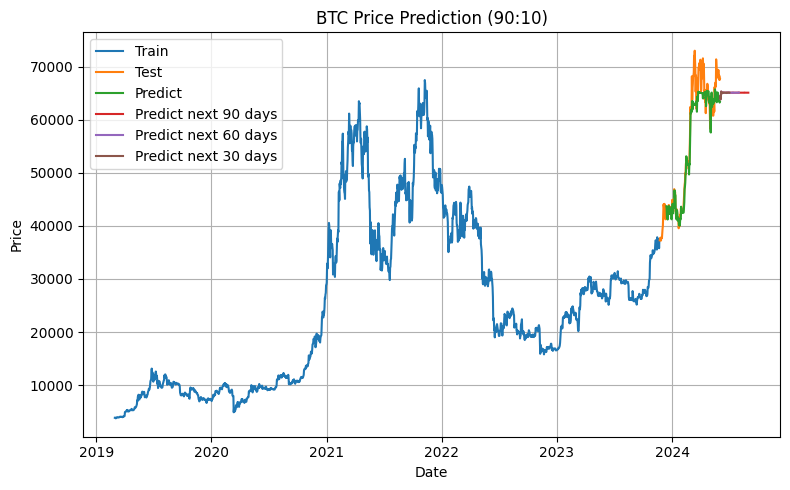

In [119]:
plt.figure(figsize=(8, 5))

train_data_index = data.index[:len(train_data)]
plt.plot(data.index[:len(train_data)], train_data, label="Train")
test_data_index = data.index[len(train_data):len(train_data) + len(test_data)]
plt.plot(test_data_index, test_data, label="Test")

predict_data_index = data.index[len(train_data) + window_size:len(train_data) + window_size + len(y_pred)]
plt.plot(predict_data_index, y_pred.flatten(), label="Predict", linestyle="-")

plt.plot(future_index[-90:], future_prices_90[-90:].flatten(), label="Predict next 90 days")
plt.plot(future_index[:60], future_prices_90[:60].flatten(), label="Predict next 60 days")
plt.plot(future_index[:30], future_prices_90[:30].flatten(), label="Predict next 30 days")
plt.title('BTC Price Prediction (90:10)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 8. ETH/USD Dataset (Data split 9:1)

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [121]:
path = "../Dataset/ETH_USD-Binance-Historical-Data-1_New.csv"
data = pd.read_csv(path, index_col='Date', parse_dates=True)
data

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2024-06-01,"3,815.93","3,765.83","3,832.37","3,753.29",132.67K,1.42%
2024-05-31,"3,762.59","3,748.31","3,845.00","3,724.51",273.40K,0.39%
2024-05-30,"3,747.91","3,767.15","3,824.91","3,703.70",277.03K,-0.58%
2024-05-29,"3,769.65","3,847.76","3,886.39","3,745.70",334.76K,-1.97%
2024-05-28,"3,845.56","3,894.21","3,929.20","3,775.00",416.24K,-1.25%
...,...,...,...,...,...,...
2019-03-05,136.59,125.75,137.86,125.14,1.04M,8.61%
2019-03-04,125.76,130.44,130.95,122.85,943.18K,-3.59%
2019-03-03,130.45,132.54,134.58,128.65,786.86K,-1.58%


In [122]:
data = data.sort_index(ascending=True)
data['Price'] = data['Price'].replace(',', '', regex=True).astype(float)
data.dropna(inplace=True)
data = data[['Price']]
data

,Price
Date,
2019-03-01,135.31
2019-03-02,132.54
2019-03-03,130.45
2019-03-04,125.76
2019-03-05,136.59
...,...
2024-05-28,3845.56
2024-05-29,3769.65
2024-05-30,3747.91


In [123]:
scaler = MinMaxScaler()
price = scaler.fit_transform(data['Price'].values.reshape(-1, 1))

train_size = int(len(price) * 0.9)
test_size = len(price) - train_size

train_data = price[:train_size]
test_data = price[train_size:]

In [124]:
def create_dataset(data, window_size, slide_step):
    X, y = [], []
    for i in range(window_size, len(data) - slide_step + 1):
        X.append(data[i - window_size:i])
        y.append(data[i + slide_step - 1])
    return np.array(X), np.array(y)

In [125]:
window_sizes = [7, 14, 21, 30]
slide_steps = [1, 2, 3, 7]
best_params = {'window_size': None, 'slide_step': None, 'score': float('inf')}
for window_size in window_sizes:
    for slide_step in slide_steps:
        X_train, y_train = create_dataset(train_data, window_size, slide_step)
        X_test, y_test = create_dataset(test_data, window_size, slide_step)

        X_train = X_train.reshape(X_train.shape[0], -1)
        X_test = X_test.reshape(X_test.shape[0], -1)

        model = RandomForestRegressor(n_estimators=100, max_depth=10)
        model.fit(X_train, y_train)
        y_pred1 = model.predict(X_test)
        mean_score = mean_squared_error(y_test, y_pred1)

        if mean_score < best_params['score']:
            best_params['window_size'] = window_size
            best_params['slide_step'] = slide_step
            best_params['score'] = mean_score

window_size = best_params['window_size']
slide_step = best_params['slide_step']

print(f"Best Parameters: Window Size = {window_size}, Slide Step = {slide_step}")


c:\Users\ADMINS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


c:\Users\ADMINS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\ADMINS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\ADMINS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\ADMINS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1474: DataCon

Best Parameters: Window Size = 7, Slide Step = 1


In [126]:
X_train, y_train = create_dataset(train_data, window_size, slide_step)
X_test, y_test = create_dataset(test_data, window_size, slide_step)

X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

In [127]:
model = RandomForestRegressor(n_estimators=100, max_depth=10)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_test = scaler.inverse_transform(y_test)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))

c:\Users\ADMINS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [128]:
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"MAE: {mae:.2f}")

RMSE: 118.05
MAPE: 2.91%
MAE: 87.14


In [129]:
def forecast_future_prices(model, last_window, window_size, scaler, days):
    future_prices = []
    current_window = last_window

    for _ in range(days):
        next_price = model.predict(current_window.reshape(1, -1))
        future_prices.append(next_price[0])
        current_window = np.append(current_window[1:], np.array([next_price]).
reshape(-1, current_window.shape[1]), axis=0)

    future_prices = np.array(future_prices).reshape(-1, 1)
    return scaler.inverse_transform(future_prices)

last_window = price[-window_size:]

future_prices_90 = forecast_future_prices(model, last_window, window_size,scaler, days=90)

In [130]:
train_data = scaler.inverse_transform(train_data)
test_data = scaler.inverse_transform(test_data)
y_train = scaler.inverse_transform(y_train)

In [131]:
last_timestep = data.index[-1]
future_index = pd.date_range(start=last_timestep + pd.DateOffset(days=1), 
periods=90)
future_index

DatetimeIndex(['2024-06-02', '2024-06-03', '2024-06-04', '2024-06-05',
               '2024-06-06', '2024-06-07', '2024-06-08', '2024-06-09',
               '2024-06-10', '2024-06-11', '2024-06-12', '2024-06-13',
               '2024-06-14', '2024-06-15', '2024-06-16', '2024-06-17',
               '2024-06-18', '2024-06-19', '2024-06-20', '2024-06-21',
               '2024-06-22', '2024-06-23', '2024-06-24', '2024-06-25',
               '2024-06-26', '2024-06-27', '2024-06-28', '2024-06-29',
               '2024-06-30', '2024-07-01', '2024-07-02', '2024-07-03',
               '2024-07-04', '2024-07-05', '2024-07-06', '2024-07-07',
               '2024-07-08', '2024-07-09', '2024-07-10', '2024-07-11',
               '2024-07-12', '2024-07-13', '2024-07-14', '2024-07-15',
               '2024-07-16', '2024-07-17', '2024-07-18', '2024-07-19',
               '2024-07-20', '2024-07-21', '2024-07-22', '2024-07-23',
               '2024-07-24', '2024-07-25', '2024-07-26', '2024-07-27',
      

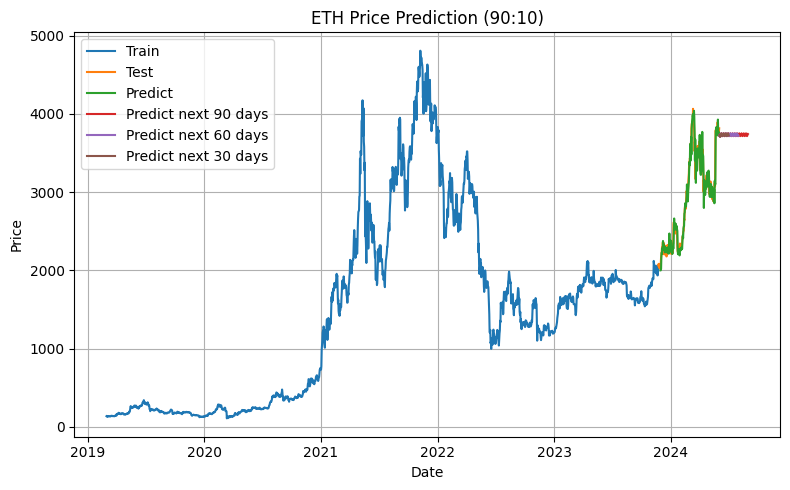

In [132]:
plt.figure(figsize=(8, 5))

train_data_index = data.index[:len(train_data)]
plt.plot(data.index[:len(train_data)], train_data, label="Train")
test_data_index = data.index[len(train_data):len(train_data) + len(test_data)]
plt.plot(test_data_index, test_data, label="Test")

predict_data_index = data.index[len(train_data) + window_size:len(train_data) + window_size + len(y_pred)]
plt.plot(predict_data_index, y_pred.flatten(), label="Predict", linestyle="-")

plt.plot(future_index[-90:], future_prices_90[-90:].flatten(), label="Predict next 90 days")
plt.plot(future_index[:60], future_prices_90[:60].flatten(), label="Predict next 60 days")
plt.plot(future_index[:30], future_prices_90[:30].flatten(), label="Predict next 30 days")
plt.title('ETH Price Prediction (90:10)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 9. BNB/USD Dataset (Data split 9:1)

In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [148]:
#import data
path = "../Dataset/BNB_USD-Binance-Historical-Data_New.csv"
data = pd.read_csv(path, index_col='Date', parse_dates=True)
data

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2024-06-01,601.80,594.00,608.20,593.20,156.40K,1.35%
2024-05-31,593.80,595.00,598.90,590.10,168.61K,-0.20%
2024-05-30,595.00,595.70,601.80,586.60,225.46K,-0.10%
2024-05-29,595.60,601.90,603.60,593.30,212.71K,-1.01%
2024-05-28,601.70,603.80,605.50,594.30,284.87K,-0.35%
...,...,...,...,...,...,...
2019-03-05,13.65,11.40,13.74,11.40,8.34M,19.61%
2019-03-04,11.41,11.45,11.51,10.88,2.74M,-0.29%
2019-03-03,11.45,11.74,11.86,11.20,2.86M,-2.58%


In [149]:
data = data.sort_index(ascending=True)
data['Price'] = data['Price'].replace(',', '', regex=True).astype(float)
data.dropna(inplace=True)
data = data[['Price']]
data

,Price
Date,
2019-03-01,11.35
2019-03-02,11.75
2019-03-03,11.45
2019-03-04,11.41
2019-03-05,13.65
...,...
2024-05-28,601.70
2024-05-29,595.60
2024-05-30,595.00


In [150]:
scaler = MinMaxScaler()
price = scaler.fit_transform(data['Price'].values.reshape(-1, 1))

train_size = int(len(price) * 0.9)
test_size = len(price) - train_size

train_data = price[:train_size]
test_data = price[train_size:]

In [151]:
def create_dataset(data, window_size, slide_step):
    X, y = [], []
    for i in range(window_size, len(data) - slide_step + 1):
        X.append(data[i - window_size:i])
        y.append(data[i + slide_step - 1])
    return np.array(X), np.array(y)


In [152]:
window_sizes = [7, 14, 21, 30]
slide_steps = [1, 2, 3, 7]
best_params = {'window_size': None, 'slide_step': None, 'score': float('inf')}
for window_size in window_sizes:
    for slide_step in slide_steps:
        X_train, y_train = create_dataset(train_data, window_size, slide_step)
        X_test, y_test = create_dataset(test_data, window_size, slide_step)

        X_train = X_train.reshape(X_train.shape[0], -1)
        X_test = X_test.reshape(X_test.shape[0], -1)

        model = RandomForestRegressor(n_estimators=100, max_depth=10)
        model.fit(X_train, y_train)
        y_pred1 = model.predict(X_test)
        mean_score = mean_squared_error(y_test, y_pred1)

        if mean_score < best_params['score']:
            best_params['window_size'] = window_size
            best_params['slide_step'] = slide_step
            best_params['score'] = mean_score

window_size = best_params['window_size']
slide_step = best_params['slide_step']

print(f"Best Parameters: Window Size = {window_size}, Slide Step = {slide_step}")


c:\Users\ADMINS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\ADMINS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\ADMINS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\ADMINS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1474: DataCon

Best Parameters: Window Size = 14, Slide Step = 1


In [153]:
X_train, y_train = create_dataset(train_data, window_size, slide_step)
X_test, y_test = create_dataset(test_data, window_size, slide_step)

X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

In [154]:
model = RandomForestRegressor(n_estimators=100, max_depth=10)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_test = scaler.inverse_transform(y_test)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))

c:\Users\ADMINS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [155]:
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"MAE: {mae:.2f}")

RMSE: 17.45
MAPE: 2.45%
MAE: 11.20


In [156]:
def forecast_future_prices(model, last_window, window_size, scaler, days):
    future_prices = []
    current_window = last_window

    for _ in range(days):
        next_price = model.predict(current_window.reshape(1, -1))
        future_prices.append(next_price[0])
        current_window = np.append(current_window[1:], np.array([next_price]).
reshape(-1, current_window.shape[1]), axis=0)

    future_prices = np.array(future_prices).reshape(-1, 1)
    return scaler.inverse_transform(future_prices)

last_window = price[-window_size:]

future_prices_90 = forecast_future_prices(model, last_window, window_size,scaler, days=90)

In [157]:
train_data = scaler.inverse_transform(train_data)
test_data = scaler.inverse_transform(test_data)
y_train = scaler.inverse_transform(y_train)

In [158]:
last_timestep = data.index[-1]
future_index = pd.date_range(start=last_timestep + pd.DateOffset(days=1), periods=90)
future_index

DatetimeIndex(['2024-06-02', '2024-06-03', '2024-06-04', '2024-06-05',
               '2024-06-06', '2024-06-07', '2024-06-08', '2024-06-09',
               '2024-06-10', '2024-06-11', '2024-06-12', '2024-06-13',
               '2024-06-14', '2024-06-15', '2024-06-16', '2024-06-17',
               '2024-06-18', '2024-06-19', '2024-06-20', '2024-06-21',
               '2024-06-22', '2024-06-23', '2024-06-24', '2024-06-25',
               '2024-06-26', '2024-06-27', '2024-06-28', '2024-06-29',
               '2024-06-30', '2024-07-01', '2024-07-02', '2024-07-03',
               '2024-07-04', '2024-07-05', '2024-07-06', '2024-07-07',
               '2024-07-08', '2024-07-09', '2024-07-10', '2024-07-11',
               '2024-07-12', '2024-07-13', '2024-07-14', '2024-07-15',
               '2024-07-16', '2024-07-17', '2024-07-18', '2024-07-19',
               '2024-07-20', '2024-07-21', '2024-07-22', '2024-07-23',
               '2024-07-24', '2024-07-25', '2024-07-26', '2024-07-27',
      

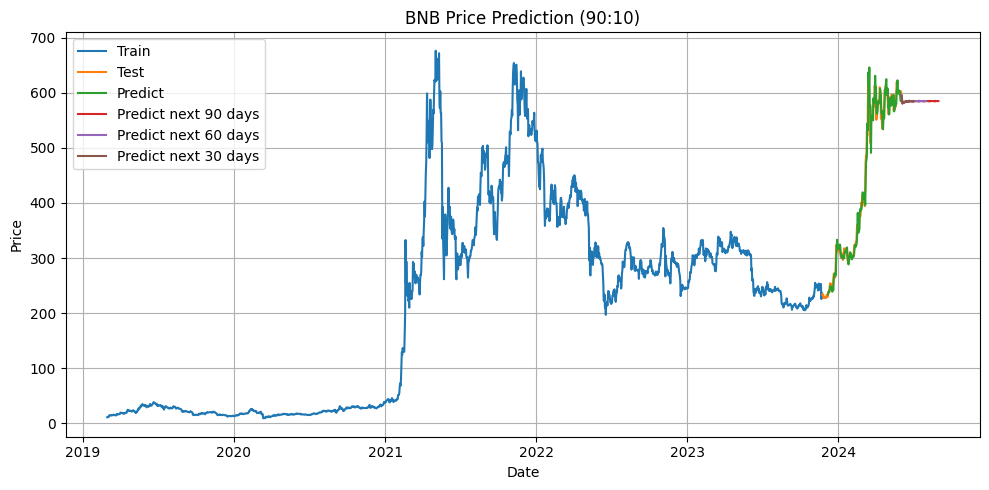

In [159]:
plt.figure(figsize=(8, 5))

train_data_index = data.index[:len(train_data)]
plt.plot(data.index[:len(train_data)], train_data, label="Train")
test_data_index = data.index[len(train_data):len(train_data) + len(test_data)]
plt.plot(test_data_index, test_data, label="Test")

predict_data_index = data.index[len(train_data) + window_size:len(train_data) + window_size + len(y_pred)]
plt.plot(predict_data_index, y_pred.flatten(), label="Predict", linestyle="-")

plt.plot(future_index[-90:], future_prices_90[-90:].flatten(), label="Predict next 90 days")
plt.plot(future_index[:60], future_prices_90[:60].flatten(), label="Predict next 60 days")
plt.plot(future_index[:30], future_prices_90[:30].flatten(), label="Predict next 30 days")
plt.title('BNB Price Prediction (90:10)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()